# AMSA: Feature Engineering

Engineering new features can have significant impact on our machine learning model performances. But we have to get it right to maximize the opportunity of extracting the most information out of the data that we have. To start, we can apply mutual information concept where we calculate the MI scores, to see which features seems to be the most relevant ones in explaining the variations of the target variable 'Default'. 

## Relevant libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif # for calculating the MI scores with classification due to the target variable

from imblearn.over_sampling import SMOTE

## Data

In [6]:
default_train = pd.read_csv('../data/default_train.csv')
default_train.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,High School,Part-time,Single,No,No,Education,No,0
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,PhD,Unemployed,Married,No,Yes,Home,Yes,0
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,High School,Full-time,Single,No,Yes,Auto,Yes,0
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,Bachelor's,Unemployed,Divorced,No,No,Other,No,0


## Most relevant features: Mutual information

Recall from the EDA that certain features might have potential to do a very good job of explaining whether an individual will default on their loans or not. To further confirm that, we have also calculated the mutual information scores for each features. Where an MI score indicates to what extent does knowing the value of a particular feature will reduce the uncertainty surrounding the target variable 'Default'. 

In [7]:
# Function for creating the MI scores and graphing the results of the MI scores
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(['object', 'category']): # ensures that all features that were originally 'object' or 'categorical' are converted into a factor variable
        labels, indexes = X[colname].factorize() # the result of the factorize() is an array of integers in which the original values were converted into integers, and an index that consist of the original value of that feature
        X[colname] = labels # then specify that the values of the columns are an array of integers stored in labels
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes] # discrete_features is a series of features in which its type is integer
    mi_scores = mutual_info_classif(X, y, discrete_features = discrete_features)
    mi_scores = pd.Series(mi_scores).sort_values(ascending = False)
    data = {
        'features': X.columns,
        'mi_scores': mi_scores
    }
    mi_scores = pd.DataFrame(data)
    return mi_scores

# Function for plotting the results of the calculated MI scores
def plot_mi_scores(scores): 
    plot = sns.barplot(x = scores['mi_scores'], y = scores['features'])
    for index, value in enumerate(scores['mi_scores']):
        value_str = f"{value:.4f}"
        plot.text(x = value + 0.03, y = index, s = value_str, ha = 'right', va = 'center', fontsize = 8)

In [8]:
X = default_train.drop(columns = ['Default'])
y = default_train['Default']

In [9]:
mi_scores = make_mi_scores(X, y)
mi_scores

,features,mi_scores
0,LoanID,0.359139
3,Age,0.276649
2,Income,0.230314
1,LoanAmount,0.014571
7,CreditScore,0.008573
5,MonthsEmployed,0.005088
4,NumCreditLines,0.002166
11,InterestRate,0.001028
16,LoanTerm,0.000870
9,DTIRatio,0.000733


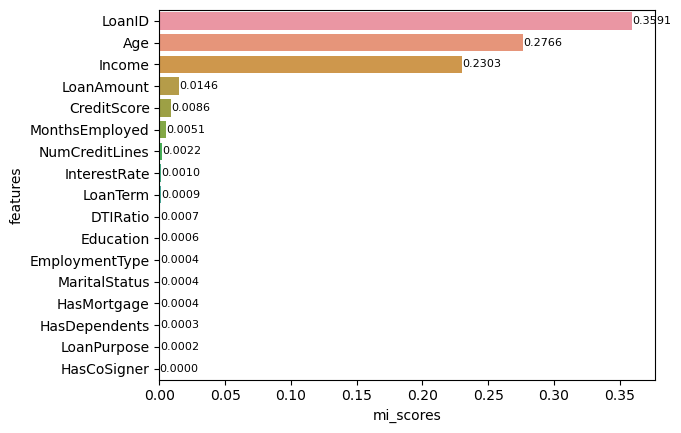

In [10]:
plot_mi_scores(mi_scores)

Based on the table and the bar graph generated above, it is evident that there are three features that are significantly most relevant for the target variable 'Default'. That is, relatively speaking, the features 'LoanID', 'Age', and 'Income' are the three features that reduce the uncertainty about the target variable 'Default' the most. In other words, the more we know about LoanID, Age, and Income, the less uncertain we are about whether an individual will default on their loans.

Intuitively, this makes sense especially with the income feature because if an individual have high income, it is probably the case that they are less likely to default on their loans because there are less incentives for them to not repay back their loans. 

In addition, it may be the case that there are certain age range that would likely to default more, signalling why it is feature with the second highest MI score. 

Interestingly, the MI score of LoanID suggest that if we know what the LoanID is, we will gain the most information about whether an individual will default on their loans. However, LoanID is just a unique identifier of a transaction and is generally generated randomly, thus it is why it has the highest MI score. If we were given a new data set, we won't be able to tell straight away whether an individual will default on their loans on not based on the LoanID. Theoretically speaking, LoanID should be ignored.

Nevertheless, based on the results, we know that we should engineering Age and Income as much as possible to extract the most information about the data as they are the two most important features for the target variable 'Default'. 

Ultimately, the mi scores for some features somewhat agrees with the EDA that we have examined earlier regarding features importance.

## Feature engineering

Now, after we have found out which features has potential of able to explain well whether an individual will default on their loans or not, we can now move on to creating new features derived from those high potential features to potentially maximize the extraction of information about the hidden patterns in the data set.

### Education and EmploymentType

It may also be possible that for individuals that finished with Master's degree and are employed full-time are less likely to default on their loans than individuals who finished with High School diploma and are employed full-time, therefore, it is also a good idea to combine these two features together to capture this potential interaction effects.

In [11]:
default_train['Education_and_EmploymentType'] = default_train['Education'] + '_' + default_train['EmploymentType']
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,Education_and_EmploymentType
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,High School,Part-time,Single,No,No,Education,No,0,High School_Part-time
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,PhD,Unemployed,Married,No,Yes,Home,Yes,0,PhD_Unemployed
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,High School,Full-time,Single,No,Yes,Auto,Yes,0,High School_Full-time
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0,High School_Self-employed
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,Bachelor's,Unemployed,Divorced,No,No,Other,No,0,Bachelor's_Unemployed
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,High School,Self-employed,Married,Yes,No,Business,Yes,0,High School_Self-employed
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,High School,Part-time,Single,No,Yes,Auto,Yes,0,High School_Part-time
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,PhD,Part-time,Married,Yes,No,Business,No,0,PhD_Part-time
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,PhD,Self-employed,Married,Yes,Yes,Education,No,0,PhD_Self-employed
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,Master's,Unemployed,Single,Yes,No,Other,Yes,0,Master's_Unemployed


### Education and MaritalStatus

In [12]:
default_train['Education_and_MaritalStatus'] = default_train['Education'] + '_' + default_train['MaritalStatus']
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,Education_and_EmploymentType,Education_and_MaritalStatus
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,High School,Part-time,Single,No,No,Education,No,0,High School_Part-time,High School_Single
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,PhD,Unemployed,Married,No,Yes,Home,Yes,0,PhD_Unemployed,PhD_Married
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,High School,Full-time,Single,No,Yes,Auto,Yes,0,High School_Full-time,High School_Single
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0,High School_Self-employed,High School_Married
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,Bachelor's,Unemployed,Divorced,No,No,Other,No,0,Bachelor's_Unemployed,Bachelor's_Divorced
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,High School,Self-employed,Married,Yes,No,Business,Yes,0,High School_Self-employed,High School_Married
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,High School,Part-time,Single,No,Yes,Auto,Yes,0,High School_Part-time,High School_Single
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,PhD,Part-time,Married,Yes,No,Business,No,0,PhD_Part-time,PhD_Married
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,PhD,Self-employed,Married,Yes,Yes,Education,No,0,PhD_Self-employed,PhD_Married
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,Master's,Unemployed,Single,Yes,No,Other,Yes,0,Master's_Unemployed,Master's_Single


### Education and HasMortgage

In [13]:
default_train['Education_and_HasMortgage'] = default_train['Education'] + '_' + default_train['HasMortgage']
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,Education_and_EmploymentType,Education_and_MaritalStatus,Education_and_HasMortgage
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,Part-time,Single,No,No,Education,No,0,High School_Part-time,High School_Single,High School_No
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,Unemployed,Married,No,Yes,Home,Yes,0,PhD_Unemployed,PhD_Married,PhD_No
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,Full-time,Single,No,Yes,Auto,Yes,0,High School_Full-time,High School_Single,High School_No
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,Self-employed,Married,Yes,Yes,Auto,Yes,0,High School_Self-employed,High School_Married,High School_Yes
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,Unemployed,Divorced,No,No,Other,No,0,Bachelor's_Unemployed,Bachelor's_Divorced,Bachelor's_No
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,Self-employed,Married,Yes,No,Business,Yes,0,High School_Self-employed,High School_Married,High School_Yes
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,Part-time,Single,No,Yes,Auto,Yes,0,High School_Part-time,High School_Single,High School_No
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,Part-time,Married,Yes,No,Business,No,0,PhD_Part-time,PhD_Married,PhD_Yes
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,Self-employed,Married,Yes,Yes,Education,No,0,PhD_Self-employed,PhD_Married,PhD_Yes
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,Unemployed,Single,Yes,No,Other,Yes,0,Master's_Unemployed,Master's_Single,Master's_Yes


### EmploymentType and MaritalStatus

It may be possible that for individuals that are unemployed and married might be more likely to default on their loans and for those individuals that are employed and single will be less likely to default on their loans because they only have to take care of themselves, therefore, it is a good idea that we combine these two features together as a string so that we can potentially capture this kind of relationships.

In [14]:
default_train['EmploymentType_and_MaritalStatus'] = default_train['EmploymentType'] + '_' + default_train['MaritalStatus']
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,Education_and_EmploymentType,Education_and_MaritalStatus,Education_and_HasMortgage,EmploymentType_and_MaritalStatus
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,Single,No,No,Education,No,0,High School_Part-time,High School_Single,High School_No,Part-time_Single
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,Married,No,Yes,Home,Yes,0,PhD_Unemployed,PhD_Married,PhD_No,Unemployed_Married
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,Single,No,Yes,Auto,Yes,0,High School_Full-time,High School_Single,High School_No,Full-time_Single
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,Married,Yes,Yes,Auto,Yes,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,Divorced,No,No,Other,No,0,Bachelor's_Unemployed,Bachelor's_Divorced,Bachelor's_No,Unemployed_Divorced
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,Married,Yes,No,Business,Yes,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,Single,No,Yes,Auto,Yes,0,High School_Part-time,High School_Single,High School_No,Part-time_Single
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,Married,Yes,No,Business,No,0,PhD_Part-time,PhD_Married,PhD_Yes,Part-time_Married
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,Married,Yes,Yes,Education,No,0,PhD_Self-employed,PhD_Married,PhD_Yes,Self-employed_Married
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,Single,Yes,No,Other,Yes,0,Master's_Unemployed,Master's_Single,Master's_Yes,Unemployed_Single


### EmploymentType and HasMortgage

In [15]:
default_train['EmploymentType_and_HasMortgage'] = default_train['EmploymentType'] + '_' + default_train['HasMortgage']
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,Education_and_EmploymentType,Education_and_MaritalStatus,Education_and_HasMortgage,EmploymentType_and_MaritalStatus,EmploymentType_and_HasMortgage
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,No,No,Education,No,0,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,No,Yes,Home,Yes,0,PhD_Unemployed,PhD_Married,PhD_No,Unemployed_Married,Unemployed_No
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,No,Yes,Auto,Yes,0,High School_Full-time,High School_Single,High School_No,Full-time_Single,Full-time_No
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,Yes,Yes,Auto,Yes,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,No,No,Other,No,0,Bachelor's_Unemployed,Bachelor's_Divorced,Bachelor's_No,Unemployed_Divorced,Unemployed_No
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,Yes,No,Business,Yes,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,No,Yes,Auto,Yes,0,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,Yes,No,Business,No,0,PhD_Part-time,PhD_Married,PhD_Yes,Part-time_Married,Part-time_Yes
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,Yes,Yes,Education,No,0,PhD_Self-employed,PhD_Married,PhD_Yes,Self-employed_Married,Self-employed_Yes
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,Yes,No,Other,Yes,0,Master's_Unemployed,Master's_Single,Master's_Yes,Unemployed_Single,Unemployed_Yes


### MaritalStatus and HasMortgage

In [16]:
default_train['MaritalStatus_and_HasMortgage'] = default_train['MaritalStatus'] + '_' + default_train['HasMortgage']
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,HasDependents,LoanPurpose,HasCoSigner,Default,Education_and_EmploymentType,Education_and_MaritalStatus,Education_and_HasMortgage,EmploymentType_and_MaritalStatus,EmploymentType_and_HasMortgage,MaritalStatus_and_HasMortgage
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,No,Education,No,0,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,Yes,Home,Yes,0,PhD_Unemployed,PhD_Married,PhD_No,Unemployed_Married,Unemployed_No,Married_No
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,Yes,Auto,Yes,0,High School_Full-time,High School_Single,High School_No,Full-time_Single,Full-time_No,Single_No
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,Yes,Auto,Yes,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,No,Other,No,0,Bachelor's_Unemployed,Bachelor's_Divorced,Bachelor's_No,Unemployed_Divorced,Unemployed_No,Divorced_No
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,No,Business,Yes,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,Yes,Auto,Yes,0,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,No,Business,No,0,PhD_Part-time,PhD_Married,PhD_Yes,Part-time_Married,Part-time_Yes,Married_Yes
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,Yes,Education,No,0,PhD_Self-employed,PhD_Married,PhD_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,No,Other,Yes,0,Master's_Unemployed,Master's_Single,Master's_Yes,Unemployed_Single,Unemployed_Yes,Single_Yes


### Ratio of LoanAmount to Income

In [17]:
default_train['LoanAmount_to_Income'] = default_train['LoanAmount'] / default_train['Income']
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,LoanPurpose,HasCoSigner,Default,Education_and_EmploymentType,Education_and_MaritalStatus,Education_and_HasMortgage,EmploymentType_and_MaritalStatus,EmploymentType_and_HasMortgage,MaritalStatus_and_HasMortgage,LoanAmount_to_Income
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,Education,No,0,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No,0.719494
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,Home,Yes,0,PhD_Unemployed,PhD_Married,PhD_No,Unemployed_Married,Unemployed_No,Married_No,1.719571
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,Auto,Yes,0,High School_Full-time,High School_Single,High School_No,Full-time_Single,Full-time_No,Single_No,1.510291
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,Auto,Yes,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,1.581735
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,Other,No,0,Bachelor's_Unemployed,Bachelor's_Divorced,Bachelor's_No,Unemployed_Divorced,Unemployed_No,Divorced_No,0.195565
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,Business,Yes,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,0.788592
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,Auto,Yes,0,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No,6.266315
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,Business,No,0,PhD_Part-time,PhD_Married,PhD_Yes,Part-time_Married,Part-time_Yes,Married_Yes,0.614820
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,Education,No,0,PhD_Self-employed,PhD_Married,PhD_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,2.907872
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,Other,Yes,0,Master's_Unemployed,Master's_Single,Master's_Yes,Unemployed_Single,Unemployed_Yes,Single_Yes,3.138207


### Simple interest: LoanAmount and InterestRate

In [18]:
default_train['SimpleInterest'] = default_train['InterestRate'] * default_train['LoanAmount']
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,HasCoSigner,Default,Education_and_EmploymentType,Education_and_MaritalStatus,Education_and_HasMortgage,EmploymentType_and_MaritalStatus,EmploymentType_and_HasMortgage,MaritalStatus_and_HasMortgage,LoanAmount_to_Income,SimpleInterest
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,No,0,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No,0.719494,797374.92
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,Yes,0,PhD_Unemployed,PhD_Married,PhD_No,Unemployed_Married,Unemployed_No,Married_No,1.719571,1749684.20
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,Yes,0,High School_Full-time,High School_Single,High School_No,Full-time_Single,Full-time_No,Single_No,1.510291,2468936.00
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,Yes,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,1.581735,2716204.44
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,No,0,Bachelor's_Unemployed,Bachelor's_Divorced,Bachelor's_No,Unemployed_Divorced,Unemployed_No,Divorced_No,0.195565,66199.00
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,Yes,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,0.788592,1452432.20
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,Yes,0,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No,6.266315,345649.92
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,No,0,PhD_Part-time,PhD_Married,PhD_Yes,Part-time_Married,Part-time_Yes,Married_Yes,0.614820,1444309.60
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,No,0,PhD_Self-employed,PhD_Married,PhD_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,2.907872,259832.20
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,Yes,0,Master's_Unemployed,Master's_Single,Master's_Yes,Unemployed_Single,Unemployed_Yes,Single_Yes,3.138207,1473289.68


### Debt amount

In [19]:
default_train['Debt'] = default_train['Income'] * default_train['DTIRatio']
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,Default,Education_and_EmploymentType,Education_and_MaritalStatus,Education_and_HasMortgage,EmploymentType_and_MaritalStatus,EmploymentType_and_HasMortgage,MaritalStatus_and_HasMortgage,LoanAmount_to_Income,SimpleInterest,Debt
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,0,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No,0.719494,797374.92,37131.90
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,0,PhD_Unemployed,PhD_Married,PhD_No,Unemployed_Married,Unemployed_No,Married_No,1.719571,1749684.20,88420.15
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,0,High School_Full-time,High School_Single,High School_No,Full-time_Single,Full-time_No,Single_No,1.510291,2468936.00,12789.59
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,1.581735,2716204.44,18247.98
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,0,Bachelor's_Unemployed,Bachelor's_Divorced,Bachelor's_No,Unemployed_Divorced,Unemployed_No,Divorced_No,0.195565,66199.00,52502.32
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,0,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,0.788592,1452432.20,13028.84
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,0,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No,6.266315,345649.92,9357.50
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,0,PhD_Part-time,PhD_Married,PhD_Yes,Part-time_Married,Part-time_Yes,Married_Yes,0.614820,1444309.60,17841.72
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,0,PhD_Self-employed,PhD_Married,PhD_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,2.907872,259832.20,3479.30
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,0,Master's_Unemployed,Master's_Single,Master's_Yes,Unemployed_Single,Unemployed_Yes,Single_Yes,3.138207,1473289.68,44034.88


### Monthly loan amount

In [20]:
default_train['MonthlyLoanAmount'] = default_train['LoanAmount'] / default_train['LoanTerm']
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,Education_and_EmploymentType,Education_and_MaritalStatus,Education_and_HasMortgage,EmploymentType_and_MaritalStatus,EmploymentType_and_HasMortgage,MaritalStatus_and_HasMortgage,LoanAmount_to_Income,SimpleInterest,Debt,MonthlyLoanAmount
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No,0.719494,797374.92,37131.90,1141.716667
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,PhD_Unemployed,PhD_Married,PhD_No,Unemployed_Married,Unemployed_No,Married_No,1.719571,1749684.20,88420.15,3898.583333
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,High School_Full-time,High School_Single,High School_No,Full-time_Single,Full-time_No,Single_No,1.510291,2468936.00,12789.59,4877.777778
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,1.581735,2716204.44,18247.98,12659.416667
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,Bachelor's_Unemployed,Bachelor's_Divorced,Bachelor's_No,Unemployed_Divorced,Unemployed_No,Divorced_No,0.195565,66199.00,52502.32,450.333333
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,High School_Self-employed,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,0.788592,1452432.20,13028.84,1945.916667
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,High School_Part-time,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No,6.266315,345649.92,9357.50,12859.000000
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,PhD_Part-time,PhD_Married,PhD_Yes,Part-time_Married,Part-time_Yes,Married_Yes,0.614820,1444309.60,17841.72,2539.222222
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,PhD_Self-employed,PhD_Married,PhD_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,2.907872,259832.20,3479.30,3832.333333
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,Master's_Unemployed,Master's_Single,Master's_Yes,Unemployed_Single,Unemployed_Yes,Single_Yes,3.138207,1473289.68,44034.88,18574.000000


### Group transforms: Average income per categories

In [21]:
# average income per different group of educational background
default_train['AverageIncome_Education'] = (default_train.groupby('Education'))['Income'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,Education_and_MaritalStatus,Education_and_HasMortgage,EmploymentType_and_MaritalStatus,EmploymentType_and_HasMortgage,MaritalStatus_and_HasMortgage,LoanAmount_to_Income,SimpleInterest,Debt,MonthlyLoanAmount,AverageIncome_Education
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No,0.719494,797374.92,37131.90,1141.716667,82678.398426
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,PhD_Married,PhD_No,Unemployed_Married,Unemployed_No,Married_No,1.719571,1749684.20,88420.15,3898.583333,82403.184944
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,High School_Single,High School_No,Full-time_Single,Full-time_No,Single_No,1.510291,2468936.00,12789.59,4877.777778,82678.398426
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,1.581735,2716204.44,18247.98,12659.416667,82678.398426
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,Bachelor's_Divorced,Bachelor's_No,Unemployed_Divorced,Unemployed_No,Divorced_No,0.195565,66199.00,52502.32,450.333333,82569.201591
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,High School_Married,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,0.788592,1452432.20,13028.84,1945.916667,82678.398426
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,High School_Single,High School_No,Part-time_Single,Part-time_No,Single_No,6.266315,345649.92,9357.50,12859.000000,82678.398426
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,PhD_Married,PhD_Yes,Part-time_Married,Part-time_Yes,Married_Yes,0.614820,1444309.60,17841.72,2539.222222,82403.184944
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,PhD_Married,PhD_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,2.907872,259832.20,3479.30,3832.333333,82403.184944
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,Master's_Single,Master's_Yes,Unemployed_Single,Unemployed_Yes,Single_Yes,3.138207,1473289.68,44034.88,18574.000000,82778.043278


In [22]:
# average income per different group of employment type
default_train['AverageIncome_EmploymentType'] = (default_train.groupby('EmploymentType'))['Income'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,Education_and_HasMortgage,EmploymentType_and_MaritalStatus,EmploymentType_and_HasMortgage,MaritalStatus_and_HasMortgage,LoanAmount_to_Income,SimpleInterest,Debt,MonthlyLoanAmount,AverageIncome_Education,AverageIncome_EmploymentType
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,High School_No,Part-time_Single,Part-time_No,Single_No,0.719494,797374.92,37131.90,1141.716667,82678.398426,82460.536087
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,PhD_No,Unemployed_Married,Unemployed_No,Married_No,1.719571,1749684.20,88420.15,3898.583333,82403.184944,82482.325032
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,High School_No,Full-time_Single,Full-time_No,Single_No,1.510291,2468936.00,12789.59,4877.777778,82678.398426,83154.099104
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,1.581735,2716204.44,18247.98,12659.416667,82678.398426,82336.765887
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,Bachelor's_No,Unemployed_Divorced,Unemployed_No,Divorced_No,0.195565,66199.00,52502.32,450.333333,82569.201591,82482.325032
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,High School_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,0.788592,1452432.20,13028.84,1945.916667,82678.398426,82336.765887
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,High School_No,Part-time_Single,Part-time_No,Single_No,6.266315,345649.92,9357.50,12859.000000,82678.398426,82460.536087
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,PhD_Yes,Part-time_Married,Part-time_Yes,Married_Yes,0.614820,1444309.60,17841.72,2539.222222,82403.184944,82460.536087
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,PhD_Yes,Self-employed_Married,Self-employed_Yes,Married_Yes,2.907872,259832.20,3479.30,3832.333333,82403.184944,82336.765887
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,Master's_Yes,Unemployed_Single,Unemployed_Yes,Single_Yes,3.138207,1473289.68,44034.88,18574.000000,82778.043278,82482.325032


In [23]:
# average income per different group of Marital Status
default_train['AverageIncome_MaritalStatus'] = (default_train.groupby('MaritalStatus'))['Income'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,EmploymentType_and_MaritalStatus,EmploymentType_and_HasMortgage,MaritalStatus_and_HasMortgage,LoanAmount_to_Income,SimpleInterest,Debt,MonthlyLoanAmount,AverageIncome_Education,AverageIncome_EmploymentType,AverageIncome_MaritalStatus
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,Part-time_Single,Part-time_No,Single_No,0.719494,797374.92,37131.90,1141.716667,82678.398426,82460.536087,82829.272079
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,Unemployed_Married,Unemployed_No,Married_No,1.719571,1749684.20,88420.15,3898.583333,82403.184944,82482.325032,82498.614934
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,Full-time_Single,Full-time_No,Single_No,1.510291,2468936.00,12789.59,4877.777778,82678.398426,83154.099104,82829.272079
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,Self-employed_Married,Self-employed_Yes,Married_Yes,1.581735,2716204.44,18247.98,12659.416667,82678.398426,82336.765887,82498.614934
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,Unemployed_Divorced,Unemployed_No,Divorced_No,0.195565,66199.00,52502.32,450.333333,82569.201591,82482.325032,82494.926947
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,Self-employed_Married,Self-employed_Yes,Married_Yes,0.788592,1452432.20,13028.84,1945.916667,82678.398426,82336.765887,82498.614934
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,Part-time_Single,Part-time_No,Single_No,6.266315,345649.92,9357.50,12859.000000,82678.398426,82460.536087,82829.272079
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,Part-time_Married,Part-time_Yes,Married_Yes,0.614820,1444309.60,17841.72,2539.222222,82403.184944,82460.536087,82498.614934
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,Self-employed_Married,Self-employed_Yes,Married_Yes,2.907872,259832.20,3479.30,3832.333333,82403.184944,82336.765887,82498.614934
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,Unemployed_Single,Unemployed_Yes,Single_Yes,3.138207,1473289.68,44034.88,18574.000000,82778.043278,82482.325032,82829.272079


In [24]:
# average income per different group of Loan Purpose
default_train['AverageIncome_LoanPurpose'] = (default_train.groupby('LoanPurpose'))['Income'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,EmploymentType_and_HasMortgage,MaritalStatus_and_HasMortgage,LoanAmount_to_Income,SimpleInterest,Debt,MonthlyLoanAmount,AverageIncome_Education,AverageIncome_EmploymentType,AverageIncome_MaritalStatus,AverageIncome_LoanPurpose
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,Part-time_No,Single_No,0.719494,797374.92,37131.90,1141.716667,82678.398426,82460.536087,82829.272079,82413.062442
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,Unemployed_No,Married_No,1.719571,1749684.20,88420.15,3898.583333,82403.184944,82482.325032,82498.614934,82670.806495
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,Full-time_No,Single_No,1.510291,2468936.00,12789.59,4877.777778,82678.398426,83154.099104,82829.272079,82512.431196
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,Self-employed_Yes,Married_Yes,1.581735,2716204.44,18247.98,12659.416667,82678.398426,82336.765887,82498.614934,82512.431196
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,Unemployed_No,Divorced_No,0.195565,66199.00,52502.32,450.333333,82569.201591,82482.325032,82494.926947,82552.056686
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,Self-employed_Yes,Married_Yes,0.788592,1452432.20,13028.84,1945.916667,82678.398426,82336.765887,82498.614934,82883.818863
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,Part-time_No,Single_No,6.266315,345649.92,9357.50,12859.000000,82678.398426,82460.536087,82829.272079,82512.431196
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,Part-time_Yes,Married_Yes,0.614820,1444309.60,17841.72,2539.222222,82403.184944,82460.536087,82498.614934,82883.818863
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,Self-employed_Yes,Married_Yes,2.907872,259832.20,3479.30,3832.333333,82403.184944,82336.765887,82498.614934,82413.062442
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,Unemployed_Yes,Single_Yes,3.138207,1473289.68,44034.88,18574.000000,82778.043278,82482.325032,82829.272079,82552.056686


In [25]:
# average loan amount per different group of educational background
default_train['AverageLoanAmount_Education'] = (default_train.groupby('Education'))['LoanAmount'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,MaritalStatus_and_HasMortgage,LoanAmount_to_Income,SimpleInterest,Debt,MonthlyLoanAmount,AverageIncome_Education,AverageIncome_EmploymentType,AverageIncome_MaritalStatus,AverageIncome_LoanPurpose,AverageLoanAmount_Education
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,Single_No,0.719494,797374.92,37131.90,1141.716667,82678.398426,82460.536087,82829.272079,82413.062442,127817.051161
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,Married_No,1.719571,1749684.20,88420.15,3898.583333,82403.184944,82482.325032,82498.614934,82670.806495,127996.778868
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,Single_No,1.510291,2468936.00,12789.59,4877.777778,82678.398426,83154.099104,82829.272079,82512.431196,127817.051161
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,Married_Yes,1.581735,2716204.44,18247.98,12659.416667,82678.398426,82336.765887,82498.614934,82512.431196,127817.051161
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,Divorced_No,0.195565,66199.00,52502.32,450.333333,82569.201591,82482.325032,82494.926947,82552.056686,127482.361552
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,Married_Yes,0.788592,1452432.20,13028.84,1945.916667,82678.398426,82336.765887,82498.614934,82883.818863,127817.051161
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,Single_No,6.266315,345649.92,9357.50,12859.000000,82678.398426,82460.536087,82829.272079,82512.431196,127817.051161
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,Married_Yes,0.614820,1444309.60,17841.72,2539.222222,82403.184944,82460.536087,82498.614934,82883.818863,127996.778868
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,Married_Yes,2.907872,259832.20,3479.30,3832.333333,82403.184944,82336.765887,82498.614934,82413.062442,127996.778868
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,Single_Yes,3.138207,1473289.68,44034.88,18574.000000,82778.043278,82482.325032,82829.272079,82552.056686,127591.365508


In [26]:
# average loan amount per different group of employment type
default_train['AverageLoanAmount_EmploymentType'] = (default_train.groupby('EmploymentType'))['LoanAmount'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,LoanAmount_to_Income,SimpleInterest,Debt,MonthlyLoanAmount,AverageIncome_Education,AverageIncome_EmploymentType,AverageIncome_MaritalStatus,AverageIncome_LoanPurpose,AverageLoanAmount_Education,AverageLoanAmount_EmploymentType
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,0.719494,797374.92,37131.90,1141.716667,82678.398426,82460.536087,82829.272079,82413.062442,127817.051161,127485.043366
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,1.719571,1749684.20,88420.15,3898.583333,82403.184944,82482.325032,82498.614934,82670.806495,127996.778868,128203.746229
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,1.510291,2468936.00,12789.59,4877.777778,82678.398426,83154.099104,82829.272079,82512.431196,127817.051161,127387.110095
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,1.581735,2716204.44,18247.98,12659.416667,82678.398426,82336.765887,82498.614934,82512.431196,127817.051161,127809.500750
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,0.195565,66199.00,52502.32,450.333333,82569.201591,82482.325032,82494.926947,82552.056686,127482.361552,128203.746229
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,0.788592,1452432.20,13028.84,1945.916667,82678.398426,82336.765887,82498.614934,82883.818863,127817.051161,127809.500750
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,6.266315,345649.92,9357.50,12859.000000,82678.398426,82460.536087,82829.272079,82512.431196,127817.051161,127485.043366
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,0.614820,1444309.60,17841.72,2539.222222,82403.184944,82460.536087,82498.614934,82883.818863,127996.778868,127485.043366
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,2.907872,259832.20,3479.30,3832.333333,82403.184944,82336.765887,82498.614934,82413.062442,127996.778868,127809.500750
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,3.138207,1473289.68,44034.88,18574.000000,82778.043278,82482.325032,82829.272079,82552.056686,127591.365508,128203.746229


In [27]:
# average loan amount per different group of marital status
default_train['AverageLoanAmount_MaritalStatus'] = (default_train.groupby('MaritalStatus'))['LoanAmount'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,SimpleInterest,Debt,MonthlyLoanAmount,AverageIncome_Education,AverageIncome_EmploymentType,AverageIncome_MaritalStatus,AverageIncome_LoanPurpose,AverageLoanAmount_Education,AverageLoanAmount_EmploymentType,AverageLoanAmount_MaritalStatus
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,797374.92,37131.90,1141.716667,82678.398426,82460.536087,82829.272079,82413.062442,127817.051161,127485.043366,127817.995305
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,1749684.20,88420.15,3898.583333,82403.184944,82482.325032,82498.614934,82670.806495,127996.778868,128203.746229,127362.233267
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,2468936.00,12789.59,4877.777778,82678.398426,83154.099104,82829.272079,82512.431196,127817.051161,127387.110095,127817.995305
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,2716204.44,18247.98,12659.416667,82678.398426,82336.765887,82498.614934,82512.431196,127817.051161,127809.500750,127362.233267
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,66199.00,52502.32,450.333333,82569.201591,82482.325032,82494.926947,82552.056686,127482.361552,128203.746229,127984.188932
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,1452432.20,13028.84,1945.916667,82678.398426,82336.765887,82498.614934,82883.818863,127817.051161,127809.500750,127362.233267
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,345649.92,9357.50,12859.000000,82678.398426,82460.536087,82829.272079,82512.431196,127817.051161,127485.043366,127817.995305
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,1444309.60,17841.72,2539.222222,82403.184944,82460.536087,82498.614934,82883.818863,127996.778868,127485.043366,127362.233267
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,259832.20,3479.30,3832.333333,82403.184944,82336.765887,82498.614934,82413.062442,127996.778868,127809.500750,127362.233267
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,1473289.68,44034.88,18574.000000,82778.043278,82482.325032,82829.272079,82552.056686,127591.365508,128203.746229,127817.995305


In [28]:
# average loan amount per different types of loan purpose
default_train['AverageLoanAmount_LoanPurpose'] = (default_train.groupby('LoanPurpose'))['LoanAmount'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,Debt,MonthlyLoanAmount,AverageIncome_Education,AverageIncome_EmploymentType,AverageIncome_MaritalStatus,AverageIncome_LoanPurpose,AverageLoanAmount_Education,AverageLoanAmount_EmploymentType,AverageLoanAmount_MaritalStatus,AverageLoanAmount_LoanPurpose
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,37131.90,1141.716667,82678.398426,82460.536087,82829.272079,82413.062442,127817.051161,127485.043366,127817.995305,127745.529397
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,88420.15,3898.583333,82403.184944,82482.325032,82498.614934,82670.806495,127996.778868,128203.746229,127362.233267,127819.946593
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,12789.59,4877.777778,82678.398426,83154.099104,82829.272079,82512.431196,127817.051161,127387.110095,127817.995305,128087.939356
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,18247.98,12659.416667,82678.398426,82336.765887,82498.614934,82512.431196,127817.051161,127809.500750,127362.233267,128087.939356
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,52502.32,450.333333,82569.201591,82482.325032,82494.926947,82552.056686,127482.361552,128203.746229,127984.188932,127613.084340
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,13028.84,1945.916667,82678.398426,82336.765887,82498.614934,82883.818863,127817.051161,127809.500750,127362.233267,127344.607487
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,9357.50,12859.000000,82678.398426,82460.536087,82829.272079,82512.431196,127817.051161,127485.043366,127817.995305,128087.939356
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,17841.72,2539.222222,82403.184944,82460.536087,82498.614934,82883.818863,127996.778868,127485.043366,127362.233267,127344.607487
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,3479.30,3832.333333,82403.184944,82336.765887,82498.614934,82413.062442,127996.778868,127809.500750,127362.233267,127745.529397
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,44034.88,18574.000000,82778.043278,82482.325032,82829.272079,82552.056686,127591.365508,128203.746229,127817.995305,127613.084340


In [29]:
# average credit score per different group of educational background
default_train['AverageCreditScore_Education'] = (default_train.groupby('Education'))['CreditScore'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,MonthlyLoanAmount,AverageIncome_Education,AverageIncome_EmploymentType,AverageIncome_MaritalStatus,AverageIncome_LoanPurpose,AverageLoanAmount_Education,AverageLoanAmount_EmploymentType,AverageLoanAmount_MaritalStatus,AverageLoanAmount_LoanPurpose,AverageCreditScore_Education
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,1141.716667,82678.398426,82460.536087,82829.272079,82413.062442,127817.051161,127485.043366,127817.995305,127745.529397,574.632194
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,3898.583333,82403.184944,82482.325032,82498.614934,82670.806495,127996.778868,128203.746229,127362.233267,127819.946593,574.904310
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,4877.777778,82678.398426,83154.099104,82829.272079,82512.431196,127817.051161,127387.110095,127817.995305,128087.939356,574.632194
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,12659.416667,82678.398426,82336.765887,82498.614934,82512.431196,127817.051161,127809.500750,127362.233267,128087.939356,574.632194
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,450.333333,82569.201591,82482.325032,82494.926947,82552.056686,127482.361552,128203.746229,127984.188932,127613.084340,573.373015
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,1945.916667,82678.398426,82336.765887,82498.614934,82883.818863,127817.051161,127809.500750,127362.233267,127344.607487,574.632194
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,12859.000000,82678.398426,82460.536087,82829.272079,82512.431196,127817.051161,127485.043366,127817.995305,128087.939356,574.632194
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,2539.222222,82403.184944,82460.536087,82498.614934,82883.818863,127996.778868,127485.043366,127362.233267,127344.607487,574.904310
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,3832.333333,82403.184944,82336.765887,82498.614934,82413.062442,127996.778868,127809.500750,127362.233267,127745.529397,574.904310
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,18574.000000,82778.043278,82482.325032,82829.272079,82552.056686,127591.365508,128203.746229,127817.995305,127613.084340,573.352735


In [30]:
# average credit score per different group of employment type
default_train['AverageCreditScore_EmploymentType'] = (default_train.groupby('EmploymentType'))['CreditScore'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageIncome_Education,AverageIncome_EmploymentType,AverageIncome_MaritalStatus,AverageIncome_LoanPurpose,AverageLoanAmount_Education,AverageLoanAmount_EmploymentType,AverageLoanAmount_MaritalStatus,AverageLoanAmount_LoanPurpose,AverageCreditScore_Education,AverageCreditScore_EmploymentType
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,82678.398426,82460.536087,82829.272079,82413.062442,127817.051161,127485.043366,127817.995305,127745.529397,574.632194,573.669027
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,82403.184944,82482.325032,82498.614934,82670.806495,127996.778868,128203.746229,127362.233267,127819.946593,574.904310,575.216718
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,82678.398426,83154.099104,82829.272079,82512.431196,127817.051161,127387.110095,127817.995305,128087.939356,574.632194,572.864206
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,82678.398426,82336.765887,82498.614934,82512.431196,127817.051161,127809.500750,127362.233267,128087.939356,574.632194,574.502943
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,82569.201591,82482.325032,82494.926947,82552.056686,127482.361552,128203.746229,127984.188932,127613.084340,573.373015,575.216718
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,82678.398426,82336.765887,82498.614934,82883.818863,127817.051161,127809.500750,127362.233267,127344.607487,574.632194,574.502943
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,82678.398426,82460.536087,82829.272079,82512.431196,127817.051161,127485.043366,127817.995305,128087.939356,574.632194,573.669027
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,82403.184944,82460.536087,82498.614934,82883.818863,127996.778868,127485.043366,127362.233267,127344.607487,574.904310,573.669027
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,82403.184944,82336.765887,82498.614934,82413.062442,127996.778868,127809.500750,127362.233267,127745.529397,574.904310,574.502943
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,82778.043278,82482.325032,82829.272079,82552.056686,127591.365508,128203.746229,127817.995305,127613.084340,573.352735,575.216718


In [31]:
# average credit score per different group of marital status
default_train['AverageCreditScore_MaritalStatus'] = (default_train.groupby('MaritalStatus'))['CreditScore'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageIncome_EmploymentType,AverageIncome_MaritalStatus,AverageIncome_LoanPurpose,AverageLoanAmount_Education,AverageLoanAmount_EmploymentType,AverageLoanAmount_MaritalStatus,AverageLoanAmount_LoanPurpose,AverageCreditScore_Education,AverageCreditScore_EmploymentType,AverageCreditScore_MaritalStatus
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,82460.536087,82829.272079,82413.062442,127817.051161,127485.043366,127817.995305,127745.529397,574.632194,573.669027,573.334730
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,82482.325032,82498.614934,82670.806495,127996.778868,128203.746229,127362.233267,127819.946593,574.904310,575.216718,573.972900
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,83154.099104,82829.272079,82512.431196,127817.051161,127387.110095,127817.995305,128087.939356,574.632194,572.864206,573.334730
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,82336.765887,82498.614934,82512.431196,127817.051161,127809.500750,127362.233267,128087.939356,574.632194,574.502943,573.972900
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,82482.325032,82494.926947,82552.056686,127482.361552,128203.746229,127984.188932,127613.084340,573.373015,575.216718,574.881655
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,82336.765887,82498.614934,82883.818863,127817.051161,127809.500750,127362.233267,127344.607487,574.632194,574.502943,573.972900
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,82460.536087,82829.272079,82512.431196,127817.051161,127485.043366,127817.995305,128087.939356,574.632194,573.669027,573.334730
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,82460.536087,82498.614934,82883.818863,127996.778868,127485.043366,127362.233267,127344.607487,574.904310,573.669027,573.972900
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,82336.765887,82498.614934,82413.062442,127996.778868,127809.500750,127362.233267,127745.529397,574.904310,574.502943,573.972900
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,82482.325032,82829.272079,82552.056686,127591.365508,128203.746229,127817.995305,127613.084340,573.352735,575.216718,573.334730


In [32]:
# average credit score per different type of loan purpose
default_train['AverageCreditScore_LoanPurpose'] = (default_train.groupby('LoanPurpose'))['CreditScore'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageIncome_MaritalStatus,AverageIncome_LoanPurpose,AverageLoanAmount_Education,AverageLoanAmount_EmploymentType,AverageLoanAmount_MaritalStatus,AverageLoanAmount_LoanPurpose,AverageCreditScore_Education,AverageCreditScore_EmploymentType,AverageCreditScore_MaritalStatus,AverageCreditScore_LoanPurpose
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,82829.272079,82413.062442,127817.051161,127485.043366,127817.995305,127745.529397,574.632194,573.669027,573.334730,573.350574
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,82498.614934,82670.806495,127996.778868,128203.746229,127362.233267,127819.946593,574.904310,575.216718,573.972900,575.213096
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,82829.272079,82512.431196,127817.051161,127387.110095,127817.995305,128087.939356,574.632194,572.864206,573.334730,573.918514
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,82498.614934,82512.431196,127817.051161,127809.500750,127362.233267,128087.939356,574.632194,574.502943,573.972900,573.918514
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,82494.926947,82552.056686,127482.361552,128203.746229,127984.188932,127613.084340,573.373015,575.216718,574.881655,573.840537
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,82498.614934,82883.818863,127817.051161,127809.500750,127362.233267,127344.607487,574.632194,574.502943,573.972900,573.992170
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,82829.272079,82512.431196,127817.051161,127485.043366,127817.995305,128087.939356,574.632194,573.669027,573.334730,573.918514
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,82498.614934,82883.818863,127996.778868,127485.043366,127362.233267,127344.607487,574.904310,573.669027,573.972900,573.992170
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,82498.614934,82413.062442,127996.778868,127809.500750,127362.233267,127745.529397,574.904310,574.502943,573.972900,573.350574
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,82829.272079,82552.056686,127591.365508,128203.746229,127817.995305,127613.084340,573.352735,575.216718,573.334730,573.840537


In [33]:
# average age per different group of educational background
default_train['AverageAge_Education'] = (default_train.groupby('Education'))['Age'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageIncome_LoanPurpose,AverageLoanAmount_Education,AverageLoanAmount_EmploymentType,AverageLoanAmount_MaritalStatus,AverageLoanAmount_LoanPurpose,AverageCreditScore_Education,AverageCreditScore_EmploymentType,AverageCreditScore_MaritalStatus,AverageCreditScore_LoanPurpose,AverageAge_Education
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,82413.062442,127817.051161,127485.043366,127817.995305,127745.529397,574.632194,573.669027,573.334730,573.350574,43.562929
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,82670.806495,127996.778868,128203.746229,127362.233267,127819.946593,574.904310,575.216718,573.972900,575.213096,43.453021
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,82512.431196,127817.051161,127387.110095,127817.995305,128087.939356,574.632194,572.864206,573.334730,573.918514,43.562929
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,82512.431196,127817.051161,127809.500750,127362.233267,128087.939356,574.632194,574.502943,573.972900,573.918514,43.562929
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,82552.056686,127482.361552,128203.746229,127984.188932,127613.084340,573.373015,575.216718,574.881655,573.840537,43.495902
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,82883.818863,127817.051161,127809.500750,127362.233267,127344.607487,574.632194,574.502943,573.972900,573.992170,43.562929
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,82512.431196,127817.051161,127485.043366,127817.995305,128087.939356,574.632194,573.669027,573.334730,573.918514,43.562929
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,82883.818863,127996.778868,127485.043366,127362.233267,127344.607487,574.904310,573.669027,573.972900,573.992170,43.453021
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,82413.062442,127996.778868,127809.500750,127362.233267,127745.529397,574.904310,574.502943,573.972900,573.350574,43.453021
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,82552.056686,127591.365508,128203.746229,127817.995305,127613.084340,573.352735,575.216718,573.334730,573.840537,43.561315


In [34]:
# average age per different group of employment type
default_train['AverageAge_EmploymentType'] = (default_train.groupby('EmploymentType'))['Age'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageLoanAmount_Education,AverageLoanAmount_EmploymentType,AverageLoanAmount_MaritalStatus,AverageLoanAmount_LoanPurpose,AverageCreditScore_Education,AverageCreditScore_EmploymentType,AverageCreditScore_MaritalStatus,AverageCreditScore_LoanPurpose,AverageAge_Education,AverageAge_EmploymentType
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,127817.051161,127485.043366,127817.995305,127745.529397,574.632194,573.669027,573.334730,573.350574,43.562929,43.447823
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,127996.778868,128203.746229,127362.233267,127819.946593,574.904310,575.216718,573.972900,575.213096,43.453021,43.536482
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,127817.051161,127387.110095,127817.995305,128087.939356,574.632194,572.864206,573.334730,573.918514,43.562929,43.529461
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,127817.051161,127809.500750,127362.233267,128087.939356,574.632194,574.502943,573.972900,573.918514,43.562929,43.560224
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,127482.361552,128203.746229,127984.188932,127613.084340,573.373015,575.216718,574.881655,573.840537,43.495902,43.536482
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,127817.051161,127809.500750,127362.233267,127344.607487,574.632194,574.502943,573.972900,573.992170,43.562929,43.560224
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,127817.051161,127485.043366,127817.995305,128087.939356,574.632194,573.669027,573.334730,573.918514,43.562929,43.447823
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,127996.778868,127485.043366,127362.233267,127344.607487,574.904310,573.669027,573.972900,573.992170,43.453021,43.447823
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,127996.778868,127809.500750,127362.233267,127745.529397,574.904310,574.502943,573.972900,573.350574,43.453021,43.560224
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,127591.365508,128203.746229,127817.995305,127613.084340,573.352735,575.216718,573.334730,573.840537,43.561315,43.536482


In [35]:
# average age per different group of marital status
default_train['AverageAge_MaritalStatus'] = (default_train.groupby('MaritalStatus'))['Age'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageLoanAmount_EmploymentType,AverageLoanAmount_MaritalStatus,AverageLoanAmount_LoanPurpose,AverageCreditScore_Education,AverageCreditScore_EmploymentType,AverageCreditScore_MaritalStatus,AverageCreditScore_LoanPurpose,AverageAge_Education,AverageAge_EmploymentType,AverageAge_MaritalStatus
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,127485.043366,127817.995305,127745.529397,574.632194,573.669027,573.334730,573.350574,43.562929,43.447823,43.380368
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,128203.746229,127362.233267,127819.946593,574.904310,575.216718,573.972900,575.213096,43.453021,43.536482,43.628970
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,127387.110095,127817.995305,128087.939356,574.632194,572.864206,573.334730,573.918514,43.562929,43.529461,43.380368
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,127809.500750,127362.233267,128087.939356,574.632194,574.502943,573.972900,573.918514,43.562929,43.560224,43.628970
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,128203.746229,127984.188932,127613.084340,573.373015,575.216718,574.881655,573.840537,43.495902,43.536482,43.545023
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,127809.500750,127362.233267,127344.607487,574.632194,574.502943,573.972900,573.992170,43.562929,43.560224,43.628970
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,127485.043366,127817.995305,128087.939356,574.632194,573.669027,573.334730,573.918514,43.562929,43.447823,43.380368
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,127485.043366,127362.233267,127344.607487,574.904310,573.669027,573.972900,573.992170,43.453021,43.447823,43.628970
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,127809.500750,127362.233267,127745.529397,574.904310,574.502943,573.972900,573.350574,43.453021,43.560224,43.628970
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,128203.746229,127817.995305,127613.084340,573.352735,575.216718,573.334730,573.840537,43.561315,43.536482,43.380368


In [36]:
# average age per different type of loan purposes
default_train['AverageAge_LoanPurpose'] = (default_train.groupby('LoanPurpose'))['Age'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageLoanAmount_MaritalStatus,AverageLoanAmount_LoanPurpose,AverageCreditScore_Education,AverageCreditScore_EmploymentType,AverageCreditScore_MaritalStatus,AverageCreditScore_LoanPurpose,AverageAge_Education,AverageAge_EmploymentType,AverageAge_MaritalStatus,AverageAge_LoanPurpose
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,127817.995305,127745.529397,574.632194,573.669027,573.334730,573.350574,43.562929,43.447823,43.380368,43.474027
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,127362.233267,127819.946593,574.904310,575.216718,573.972900,575.213096,43.453021,43.536482,43.628970,43.463250
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,127817.995305,128087.939356,574.632194,572.864206,573.334730,573.918514,43.562929,43.529461,43.380368,43.516306
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,127362.233267,128087.939356,574.632194,574.502943,573.972900,573.918514,43.562929,43.560224,43.628970,43.516306
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,127984.188932,127613.084340,573.373015,575.216718,574.881655,573.840537,43.495902,43.536482,43.545023,43.652605
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,127362.233267,127344.607487,574.632194,574.502943,573.972900,573.992170,43.562929,43.560224,43.628970,43.486305
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,127817.995305,128087.939356,574.632194,573.669027,573.334730,573.918514,43.562929,43.447823,43.380368,43.516306
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,127362.233267,127344.607487,574.904310,573.669027,573.972900,573.992170,43.453021,43.447823,43.628970,43.486305
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,127362.233267,127745.529397,574.904310,574.502943,573.972900,573.350574,43.453021,43.560224,43.628970,43.474027
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,127817.995305,127613.084340,573.352735,575.216718,573.334730,573.840537,43.561315,43.536482,43.380368,43.652605


In [37]:
# average number of credit lines per different educational background
default_train['AverageNumCreditLines_Education'] = (default_train.groupby('Education'))['NumCreditLines'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageLoanAmount_LoanPurpose,AverageCreditScore_Education,AverageCreditScore_EmploymentType,AverageCreditScore_MaritalStatus,AverageCreditScore_LoanPurpose,AverageAge_Education,AverageAge_EmploymentType,AverageAge_MaritalStatus,AverageAge_LoanPurpose,AverageNumCreditLines_Education
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,127745.529397,574.632194,573.669027,573.334730,573.350574,43.562929,43.447823,43.380368,43.474027,2.497016
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,127819.946593,574.904310,575.216718,573.972900,575.213096,43.453021,43.536482,43.628970,43.463250,2.500191
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,128087.939356,574.632194,572.864206,573.334730,573.918514,43.562929,43.529461,43.380368,43.516306,2.497016
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,128087.939356,574.632194,574.502943,573.972900,573.918514,43.562929,43.560224,43.628970,43.516306,2.497016
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,127613.084340,573.373015,575.216718,574.881655,573.840537,43.495902,43.536482,43.545023,43.652605,2.497279
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,127344.607487,574.632194,574.502943,573.972900,573.992170,43.562929,43.560224,43.628970,43.486305,2.497016
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,128087.939356,574.632194,573.669027,573.334730,573.918514,43.562929,43.447823,43.380368,43.516306,2.497016
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,127344.607487,574.904310,573.669027,573.972900,573.992170,43.453021,43.447823,43.628970,43.486305,2.500191
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,127745.529397,574.904310,574.502943,573.972900,573.350574,43.453021,43.560224,43.628970,43.474027,2.500191
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,127613.084340,573.352735,575.216718,573.334730,573.840537,43.561315,43.536482,43.380368,43.652605,2.500685


In [38]:
# average number of credit lines per different employment type
default_train['AverageNumCreditLines_EmploymentType'] = (default_train.groupby('EmploymentType'))['NumCreditLines'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageCreditScore_Education,AverageCreditScore_EmploymentType,AverageCreditScore_MaritalStatus,AverageCreditScore_LoanPurpose,AverageAge_Education,AverageAge_EmploymentType,AverageAge_MaritalStatus,AverageAge_LoanPurpose,AverageNumCreditLines_Education,AverageNumCreditLines_EmploymentType
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,574.632194,573.669027,573.334730,573.350574,43.562929,43.447823,43.380368,43.474027,2.497016,2.499556
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,574.904310,575.216718,573.972900,575.213096,43.453021,43.536482,43.628970,43.463250,2.500191,2.500056
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,574.632194,572.864206,573.334730,573.918514,43.562929,43.529461,43.380368,43.516306,2.497016,2.493423
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,574.632194,574.502943,573.972900,573.918514,43.562929,43.560224,43.628970,43.516306,2.497016,2.502071
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,573.373015,575.216718,574.881655,573.840537,43.495902,43.536482,43.545023,43.652605,2.497279,2.500056
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,574.632194,574.502943,573.972900,573.992170,43.562929,43.560224,43.628970,43.486305,2.497016,2.502071
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,574.632194,573.669027,573.334730,573.918514,43.562929,43.447823,43.380368,43.516306,2.497016,2.499556
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,574.904310,573.669027,573.972900,573.992170,43.453021,43.447823,43.628970,43.486305,2.500191,2.499556
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,574.904310,574.502943,573.972900,573.350574,43.453021,43.560224,43.628970,43.474027,2.500191,2.502071
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,573.352735,575.216718,573.334730,573.840537,43.561315,43.536482,43.380368,43.652605,2.500685,2.500056


In [39]:
# average number of credit lines per different marital status
default_train['AverageNumCreditLines_MaritalStatus'] = (default_train.groupby('MaritalStatus'))['NumCreditLines'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageCreditScore_EmploymentType,AverageCreditScore_MaritalStatus,AverageCreditScore_LoanPurpose,AverageAge_Education,AverageAge_EmploymentType,AverageAge_MaritalStatus,AverageAge_LoanPurpose,AverageNumCreditLines_Education,AverageNumCreditLines_EmploymentType,AverageNumCreditLines_MaritalStatus
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,573.669027,573.334730,573.350574,43.562929,43.447823,43.380368,43.474027,2.497016,2.499556,2.497106
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,575.216718,573.972900,575.213096,43.453021,43.536482,43.628970,43.463250,2.500191,2.500056,2.502948
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,572.864206,573.334730,573.918514,43.562929,43.529461,43.380368,43.516306,2.497016,2.493423,2.497106
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,574.502943,573.972900,573.918514,43.562929,43.560224,43.628970,43.516306,2.497016,2.502071,2.502948
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,575.216718,574.881655,573.840537,43.495902,43.536482,43.545023,43.652605,2.497279,2.500056,2.496293
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,574.502943,573.972900,573.992170,43.562929,43.560224,43.628970,43.486305,2.497016,2.502071,2.502948
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,573.669027,573.334730,573.918514,43.562929,43.447823,43.380368,43.516306,2.497016,2.499556,2.497106
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,573.669027,573.972900,573.992170,43.453021,43.447823,43.628970,43.486305,2.500191,2.499556,2.502948
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,574.502943,573.972900,573.350574,43.453021,43.560224,43.628970,43.474027,2.500191,2.502071,2.502948
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,575.216718,573.334730,573.840537,43.561315,43.536482,43.380368,43.652605,2.500685,2.500056,2.497106


In [40]:
# average number of credit lines per different type of loan purpose
default_train['AverageNumCreditLines_LoanPurpose'] = (default_train.groupby('LoanPurpose'))['NumCreditLines'].transform('mean')
default_train.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageCreditScore_MaritalStatus,AverageCreditScore_LoanPurpose,AverageAge_Education,AverageAge_EmploymentType,AverageAge_MaritalStatus,AverageAge_LoanPurpose,AverageNumCreditLines_Education,AverageNumCreditLines_EmploymentType,AverageNumCreditLines_MaritalStatus,AverageNumCreditLines_LoanPurpose
0,9WOZYHU33T,52,95210,68503,465,74,2,11.64,60,0.39,...,573.334730,573.350574,43.562929,43.447823,43.380368,43.474027,2.497016,2.499556,2.497106,2.506328
1,EX8Z0TNMOT,63,136031,233915,523,85,1,7.48,60,0.65,...,573.972900,575.213096,43.453021,43.536482,43.628970,43.463250,2.500191,2.500056,2.502948,2.498910
2,A9PXUMUBAA,66,116269,175600,680,113,3,14.06,36,0.11,...,573.334730,573.918514,43.562929,43.529461,43.380368,43.516306,2.497016,2.493423,2.497106,2.492009
3,TZZ1ZWQQMI,39,96042,151913,619,46,2,17.88,12,0.19,...,573.972900,573.918514,43.562929,43.560224,43.628970,43.516306,2.497016,2.502071,2.502948,2.492009
4,YZ0VY3DWUG,50,138164,27020,342,74,1,2.45,60,0.38,...,574.881655,573.840537,43.495902,43.536482,43.545023,43.652605,2.497279,2.500056,2.496293,2.493255
5,V7KNJK7ZVR,53,118444,93404,404,61,4,15.55,48,0.11,...,573.972900,573.992170,43.562929,43.560224,43.628970,43.486305,2.497016,2.502071,2.502948,2.503348
6,OZLO6RPKC1,20,24625,154308,547,54,4,2.24,12,0.38,...,573.334730,573.918514,43.562929,43.447823,43.380368,43.516306,2.497016,2.499556,2.497106,2.492009
7,22MKLTWMTI,33,148681,91412,769,31,3,15.80,36,0.12,...,573.972900,573.992170,43.453021,43.447823,43.628970,43.486305,2.500191,2.499556,2.502948,2.503348
8,H9LOFUO9IQ,27,15815,45988,595,5,4,5.65,12,0.22,...,573.972900,573.350574,43.453021,43.560224,43.628970,43.474027,2.500191,2.502071,2.502948,2.506328
9,PRPCTHQO5A,28,71024,222888,440,46,4,6.61,12,0.62,...,573.334730,573.840537,43.561315,43.536482,43.380368,43.652605,2.500685,2.500056,2.497106,2.493255


In [41]:
default_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178742 entries, 0 to 178741
Data columns (total 48 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   LoanID                                178742 non-null  object 
 1   Age                                   178742 non-null  int64  
 2   Income                                178742 non-null  int64  
 3   LoanAmount                            178742 non-null  int64  
 4   CreditScore                           178742 non-null  int64  
 5   MonthsEmployed                        178742 non-null  int64  
 6   NumCreditLines                        178742 non-null  int64  
 7   InterestRate                          178742 non-null  float64
 8   LoanTerm                              178742 non-null  int64  
 9   DTIRatio                              178742 non-null  float64
 10  Education                             178742 non-null  object 
 11  

In [42]:
default_train['LoanPurpose'].value_counts()

LoanPurpose
Business     36144
Home         35782
Education    35633
Auto         35601
Other        35582
Name: count, dtype: int64

## Dealing with class imbalance

Based on our discovery earlier, we have to deal with this issue through either upsampling or downsampling.

Notably, considering the context of this project, it is evident that our main goal is to correctly identify individuals that will default on their loans. More specifically, we want to be able to accurately predict whether an individual will default on their loan or not. As a result, we really want to minimize the degree of overfitting for our model. 

Considering this, downsampling is rationally better than umsampling as we are aiming towards the improvement of model's efficiency and by reduce overfitting. In addition, after downsampling the data, the data set will still be considerably large to a degree that our predictive analytics will be meaninful. In other words, after downsampling (the negative class), the data will contain around 30000 observations of non-defaulters and defaulters. 

Ultimately, downsampling is done using the code below.

In [43]:
# Seperate the minority and majority class
df_majority = default_train[default_train["Default"] == 0] # we found that the majority class is the non-default
df_minority = default_train[default_train["Default"] == 1] # we found that the minority class is the default

# Downsample the majority class
df_majority_downsampled = df_majority.sample(n = len(df_minority), random_state = 96789)

# Combine the downsampled majority class data frame and the minority class data frame
default_train_downsampled = pd.concat([df_majority_downsampled, df_minority])
# Shuffle the data frame randomly
default_train_downsampled = default_train_downsampled.sample(frac = 1, random_state = 123) # frac is an argument where you determine how much of the data to be sampled from a data frame, frac = 0.5 means randomly sample 50% of the data from the relevant data frame, whereas frac = 1 means randomly sample 100% of the data from the relevant data frame. Also, don't forget random_state here to ensure code reproducibility :)

default_train_downsampled.head(n = 10)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,...,AverageCreditScore_MaritalStatus,AverageCreditScore_LoanPurpose,AverageAge_Education,AverageAge_EmploymentType,AverageAge_MaritalStatus,AverageAge_LoanPurpose,AverageNumCreditLines_Education,AverageNumCreditLines_EmploymentType,AverageNumCreditLines_MaritalStatus,AverageNumCreditLines_LoanPurpose
170507,EBPZT8K4EJ,54,140874,217057,656,112,4,7.23,60,0.39,...,573.972900,573.992170,43.453021,43.560224,43.628970,43.486305,2.500191,2.502071,2.502948,2.503348
31745,OY5Q1LG6IV,58,112683,235071,670,83,1,7.01,48,0.34,...,573.972900,573.840537,43.562929,43.447823,43.628970,43.652605,2.497016,2.499556,2.502948,2.493255
19013,UICPTG78DN,36,137433,134805,835,100,4,22.84,60,0.11,...,573.972900,573.840537,43.453021,43.560224,43.628970,43.652605,2.500191,2.502071,2.502948,2.493255
116239,Q87UMND87J,42,20845,172476,397,44,1,3.58,48,0.73,...,574.881655,573.350574,43.561315,43.447823,43.545023,43.474027,2.500685,2.499556,2.496293,2.506328
112055,CBF81BXV2G,43,62444,57971,331,6,2,14.46,36,0.16,...,574.881655,573.350574,43.453021,43.529461,43.545023,43.474027,2.500191,2.493423,2.496293,2.506328
153571,6FNQWKC19B,26,17980,212819,514,101,4,6.26,60,0.52,...,574.881655,573.918514,43.495902,43.536482,43.545023,43.516306,2.497279,2.500056,2.496293,2.492009
171036,06SJXG6JZG,33,54887,214104,394,62,3,9.94,48,0.73,...,573.334730,573.918514,43.453021,43.560224,43.380368,43.516306,2.500191,2.502071,2.497106,2.492009
158906,GA5FIZ59FW,42,41735,162432,440,81,2,24.40,24,0.53,...,573.972900,573.840537,43.561315,43.536482,43.628970,43.652605,2.500685,2.500056,2.502948,2.493255
66838,5A2E0RA6B5,49,88168,224050,732,74,4,15.87,48,0.62,...,574.881655,573.918514,43.453021,43.536482,43.545023,43.516306,2.500191,2.500056,2.496293,2.492009
17353,BJ19JXJLXZ,64,74392,198299,728,91,2,12.67,48,0.18,...,573.334730,573.350574,43.562929,43.560224,43.380368,43.474027,2.497016,2.502071,2.497106,2.506328


Checking that we have resolved the class imbalance issues

In [44]:
default_elements_unique = [i for i in default_train_downsampled["Default"].unique()]

n = default_train_downsampled["Default"].value_counts()

prop = n/len(default_train_downsampled)

target_class_distribution_train_downsampled = pd.DataFrame(
    {
        "default": default_elements_unique, 
        "n": n, 
        "prop": prop
    }
)

target_class_distribution_train_downsampled

,default,n,prop
Default,,,
0,0,20757,0.5
1,1,20757,0.5


In [45]:
print(default_train_downsampled.shape)

(41514, 48)


### Using SMOTE (Synthetic Minority Oversampling Technique)

In [46]:
X = pd.DataFrame(default_train.drop(columns = ['Default']))
y = pd.DataFrame(default_train['Default'])

In [47]:
sm = SMOTE(random_state = 12345)

In [48]:
X_train_upsampled, y_train_upsampled = sm.fit_resample(X, y)

ValueError: could not convert string to float: '9WOZYHU33T'

In [ ]:
default_train_upsampled = pd.concat(X_train_upsampled, y_train_upsampled, axis = 1)

In [ ]:
default_train_upsampled

## Data exporting

Ultimately, we can save and write the newly created data frames into a csv file

In [ ]:
default_train_downsampled.to_csv(
    '../data/default_train_complete.csv', 
    index = False, 
    sep = ','
)